In [6]:
!pip install energyflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.8/700.8 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.2/502.2 kB 41.7 MB/s eta 0:00:00


In [3]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.6 MB/s eta 0:00:00


In [1]:
!pip install torch-cluster

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-cluster: filename=torch_cluster-1.6.3-cp311-cp311-linux_x86_64.whl size=2065944 sha256=d37f877b4b6c58de782717029a3e94a67d1d110cae73ea52b6961f50183f75c0
  Stored in directory: /root/.cache/pip/wheels/ef/de/7d/a4211822af99147b93800e9e204f0be21294e3c0b95b3b861a
Successfully built torch-cluster


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import tqdm
from torch_geometric.nn import EdgeConv, global_mean_pool
from torch_cluster import knn_graph
from torch_geometric.data import Data, DataLoader
import energyflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [9]:
qg_dataset = energyflow.qg_jets.load(num_data=50000, pad=True, ncol=4, generator='pythia')
x = qg_dataset[0]
y = torch.tensor(qg_dataset[1], dtype=torch.long)  # Labels: 0 (Gluon), 1 (Quark)

In [10]:
features_to_consider = [0, 1, 2, 3]  # (pT, rapidity, azimuthal angle, energy)
x = x[:, :, features_to_consider]

In [11]:
# Convert to PyG Data Format
jet_dataset = []
for i in range(len(x)):
    jet_dataset.append(Data(x=torch.tensor(x[i], dtype=torch.float), y=y[i]))

In [12]:
train_data, val_data = train_test_split(jet_dataset, test_size=0.1, random_state=42)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
class ParticleNetEdgeNet(nn.Module):
    def __init__(self, in_size, layer_size):
        super(ParticleNetEdgeNet, self).__init__()
        layers = [nn.Linear(in_size * 2, layer_size), nn.BatchNorm1d(layer_size), nn.ReLU()]
        for _ in range(2):
            layers.extend([nn.Linear(layer_size, layer_size), nn.BatchNorm1d(layer_size), nn.ReLU()])
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)


class ParticleNet(nn.Module):
    def __init__(self, node_feat_size, num_classes=2, k=16, num_edge_convs=3, layer_sizes=[64, 128, 256]):
        super(ParticleNet, self).__init__()
        self.k = k
        self.edge_nets = nn.ModuleList()
        self.edge_convs = nn.ModuleList()

        layer_sizes.insert(0, node_feat_size)
        self.output_sizes = np.cumsum(layer_sizes)

        self.edge_nets.append(ParticleNetEdgeNet(node_feat_size, layer_sizes[1]))
        self.edge_convs.append(EdgeConv(self.edge_nets[-1], aggr="mean"))

        for i in range(1, num_edge_convs):
            self.edge_nets.append(ParticleNetEdgeNet(self.output_sizes[i], layer_sizes[i + 1]))
            self.edge_convs.append(EdgeConv(self.edge_nets[-1], aggr="mean"))

        self.fc1 = nn.Linear(self.output_sizes[-1], 256)
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, data):
        x, batch = data.x, data.batch
        for i in range(len(self.edge_convs)):
            edge_index = knn_graph(x[:, :2], self.k, batch)
            x = torch.cat((self.edge_convs[i](x, edge_index), x), dim=1)
        x = global_mean_pool(x, batch)
        x = self.fc1(x)
        return self.fc2(x)

In [ ]:

model = ParticleNet(node_feat_size=len(features_to_consider), num_classes=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
model_path = "particle_net_weights.pth"

def train_test_one_epoch(model, data_loader, mode='train'):
    model.train(mode == 'train')
    running_loss, running_correct = 0.0, 0
    t = tqdm.tqdm(data_loader)
    for data in t:
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_fn(outputs, data.y)
        if mode == 'train':
            loss.backward()
            optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, dim=1)
        running_correct += torch.sum(predicted == data.y).item()
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = running_correct / len(data_loader.dataset)
    return epoch_loss, epoch_acc

if not os.path.exists(model_path):
    EPOCHS = 10
    for epoch in range(EPOCHS):
        print(f' Epoch {epoch+1}/{EPOCHS}')
        train_loss, train_acc = train_test_one_epoch(model, train_loader, mode='train')
        val_loss, val_acc = train_test_one_epoch(model, val_loader, mode='test')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    torch.save(model.state_dict(), model_path)  # Save trained model weights
else:
    model.load_state_dict(torch.load(model_path))  # Load saved model weights
    print("Loaded pre-trained model.")


def evaluate_model(model, val_loader):
    y_true, y_pred, y_prob = [], [], []
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            outputs = model(data)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            y_true.extend(data.y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs[:, 1].cpu().numpy())  # Probability of being quark
    return np.array(y_true), np.array(y_pred), np.array(y_prob)

y_true, y_pred, y_prob = evaluate_model(model, val_loader)




Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


 Epoch 1/10


100%|██████████| 40/40 [00:04<00:00,  9.18it/s]


Train Loss: 0.4960, Train Acc: 0.7670
Val Loss: 0.4700, Val Acc: 0.7860
 Epoch 2/10


100%|██████████| 40/40 [00:04<00:00,  9.16it/s]


Train Loss: 0.4816, Train Acc: 0.7772
Val Loss: 0.4908, Val Acc: 0.7836
 Epoch 3/10


100%|██████████| 40/40 [00:04<00:00,  9.25it/s]


Train Loss: 0.4797, Train Acc: 0.7792
Val Loss: 0.4705, Val Acc: 0.7932
 Epoch 4/10


100%|██████████| 40/40 [00:04<00:00,  9.21it/s]


Train Loss: 0.4783, Train Acc: 0.7790
Val Loss: 0.4657, Val Acc: 0.7854
 Epoch 5/10


100%|██████████| 40/40 [00:04<00:00,  9.15it/s]


Train Loss: 0.4754, Train Acc: 0.7828
Val Loss: 0.4676, Val Acc: 0.7864
 Epoch 6/10


100%|██████████| 40/40 [00:04<00:00,  9.19it/s]


Train Loss: 0.4743, Train Acc: 0.7821
Val Loss: 0.4804, Val Acc: 0.7876
 Epoch 7/10


100%|██████████| 40/40 [00:04<00:00,  9.18it/s]


Train Loss: 0.4735, Train Acc: 0.7826
Val Loss: 0.4739, Val Acc: 0.7920
 Epoch 8/10


100%|██████████| 40/40 [00:04<00:00,  9.17it/s]


Train Loss: 0.4710, Train Acc: 0.7830
Val Loss: 0.4732, Val Acc: 0.7762
 Epoch 9/10


100%|██████████| 40/40 [00:04<00:00,  9.12it/s]


Train Loss: 0.4687, Train Acc: 0.7850
Val Loss: 0.4813, Val Acc: 0.7870
 Epoch 10/10


100%|██████████| 40/40 [00:04<00:00,  9.07it/s]


Train Loss: 0.4700, Train Acc: 0.7854
Val Loss: 0.4628, Val Acc: 0.7916


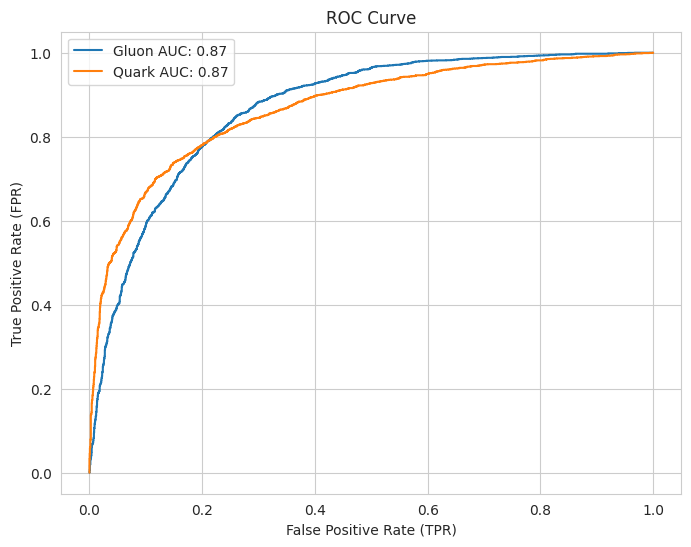

In [ ]:
plt.figure(figsize=(8, 6))
for i, label in enumerate(["Gluon", "Quark"]):
    tpr, fpr, _ = roc_curve((y_true == i), y_prob if i == 1 else 1 - y_prob)
    auc_score = auc(tpr, fpr)
    plt.plot(tpr, fpr, label=f"{label} AUC: {auc_score:.2f}")

plt.xlabel("False Positive Rate (TPR)")
plt.ylabel("True Positive Rate (FPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()



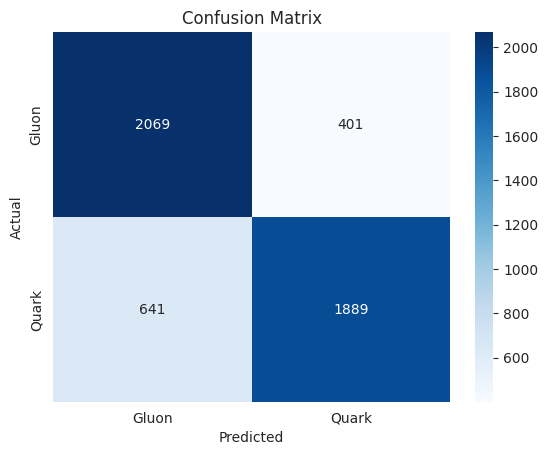

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gluon', 'Quark'], yticklabels=['Gluon', 'Quark'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()